In [663]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science','no-latex'])
import time

(650, 50, 1) (650, 1)
0.3731405178705851


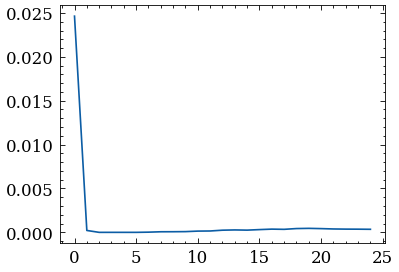

In [687]:
def dataset():
    x = np.linspace(0,40,1_000).reshape(1000,1)
    y = np.sin(x*np.pi)
    return y[:700], y[300:]
train_data, test_data = dataset()
#plt.figure(dpi = 200)
#plt.grid()
#plt.plot(train_data)

class RNN:
    def __init__(self, data, timesteps = 50, epochs = 25, units = 100, lr = 1e-4):
        self.timesteps = timesteps
        self.data = data
        self.epochs = epochs
        self.lr = lr 
        self.units = units # hidden cells 
        self.m = self.data.shape[0]
        
        # One to one
        self.in_dim = 1
        self.out_dim = 1 
        
        self.weight_init()
        self.seq_X, self.seq_Y = self.sequence_data(self.data)
        
        self.hidden = []
        self.inputs = []
        self.Loss = []
        self.outputs = []
        
    
    def weight_init(self):
        self.Wx = np.random.randn(self.units,self.in_dim)
        self.Wh = np.random.randn(self.units,self.units)
        self.Wy = np.random.randn(self.out_dim,self.units)
        
    def sequence_data(self, data):
        x, y = [], []
        for i in range(data.shape[0]-self.timesteps):
            x.append(data[i:i+self.timesteps])
            y.append(data[i+self.timesteps])

        return np.array(x), np.array(y)
        
    def sigmoid(self,z):
        return (1 / (1 + np.exp(-z)))
    
    def dsigmoid(self,z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def dtanh(self,z):
        return 1-(np.tanh(z)**2)
        
    def cell(self,x):
        xt = np.dot(self.Wx,x.reshape(1,1))
        ht = np.dot(self.Wh,self.ht)
        
        ht1 = self.sigmoid(xt + ht)
        
        self.output = np.dot(self.Wy,ht1)
                    
        self.ht = ht1    
        self.hidden.append(ht1)
        self.inputs.append(x.reshape(1,1))
        
    def forward(self, x, y):
        self.inputs = []
        self.hidden = []
        self.ht = np.random.randn(self.units,1)
        
        for step in range(self.timesteps):    
            self.cell(x[step])
        
        self.error = self.output - y
        self.loss = self.error**2
        self.outputs.append(self.output)
        
    def gradient_clip(self, W):
        return np.clip(W, -1, 1, out = W)
                        
    def backward(self):
        dL = self.error
        dWy = np.dot(dL,self.hidden[-1].T)
                
        dWx = np.zeros((self.Wx.shape))
        dWh = np.zeros((self.Wh.shape))
        
        dh = np.dot(self.error, self.Wy).T
        
        for step in reversed(range(self.timesteps-1)):
            temp = self.dsigmoid(self.hidden[step+1]) * dh
                
            dWx += np.dot(temp, self.inputs[step].T)
            dWh += np.dot(temp, self.hidden[step].T) 
             
            dh = np.dot(self.Wh, temp)
            
        # Update
        
        dWy = self.gradient_clip(dWy)
        dWh = self.gradient_clip(dWh)
        dWx = self.gradient_clip(dWx)
        
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh

            
    def train(self):
        for epoch in range(self.epochs):
            self.loss = 0
            for x,y in zip(self.seq_X, self.seq_Y):
                self.forward(x,y)
                self.backward()
            self.Loss.append(np.squeeze(self.loss / self.m))

start = time.time()  
rnn = RNN(train_data)
print(rnn.seq_X.shape, rnn.seq_Y.shape)
rnn.train()
plt.figure(dpi=120)
plt.plot(rnn.Loss)
print((time.time()-start)/60)


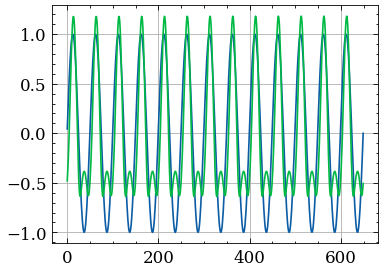

In [688]:
test_x, test_y = rnn.sequence_data(test_data)
rnn.outputs = []
for x,y in zip(test_x, test_y):
    rnn.loss = 0
    rnn.forward(x,y)

plt.figure(dpi = 120)
plt.grid()
plt.plot([i for i in range(test_y.shape[0])], test_y, np.array(rnn.outputs).reshape(test_x.shape[0],1))